In [5]:
from SyMBac.drawing import raster_cell, OPL_to_FL
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation, disk
from skimage.measure import label
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, "../") 
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale

In [21]:
def calculate_diffraction_limit(wavelength, NA, criterion):
    if criterion == "Rayleigh":
        return 0.61*wavelength/NA
    if criterion == "Abbe":
        return 0.5*wavelength/NA
    if criterion == "Sparrow":
        return 0.47*wavelength/NA

In [42]:
pixel_size = 0.0655
scale = 20
pixel_size = pixel_size/scale
NA = 1.49

In [43]:
N_molecules = np.arange(1, 30)+0.1
diffraction_limits = ["Rayleigh", "Abbe", "Sparrow"]
lengths = np.arange(1,11,1)
widths = np.arange(1,11,1)
imaging_properties = ((0.0655, 1.45))
wavelengths = (0.4, 0.5, 0.6, 0.7) #Blue, cyan, green, yellow, orange, red, far red

In [44]:
def simulate_molecule_counting(N_molecules, length, width, diffraction_criterion, wavelength, ID, imaging_properties=imaging_properties):
    pixel_size, NA = imaging_properties
    diffraction_limit = calculate_diffraction_limit(wavelength,NA, diffraction_criterion)/pixel_size
    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    volume = np.sum(OPL_cell)
    density = N_molecules/volume
    FL_cell = OPL_to_FL(OPL_cell, density = density)
    diffraction_limited_cell = dilation(FL_cell, disk(diffraction_limit/2))
    true_N_molecules = np.sum(FL_cell)
    observed_N_molecules = len(np.unique(label(diffraction_limited_cell)))-1
    if (true_N_molecules < observed_N_molecules) or (observed_N_molecules == 0):
        raise Exception(f"{N_molecules}, {length}, {width}, {diffraction_criterion},{pixel_size}")
    return true_N_molecules, observed_N_molecules, np.sum(OPL_cell), ID

In [45]:
wavelength = 0.55
diffraction_criterion = "Rayleigh"
length = 5
width = 1
N_molecules = 10

diffraction_limit = calculate_diffraction_limit(wavelength,NA, diffraction_criterion)/pixel_size
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
volume = np.sum(OPL_cell)
density = N_molecules/volume
FL_cell = OPL_to_FL(OPL_cell, density = density)
diffraction_limited_cell = dilation(FL_cell, disk(diffraction_limit/2))
true_N_molecules = np.sum(FL_cell)
observed_N_molecules = len(np.unique(label(diffraction_limited_cell)))-1

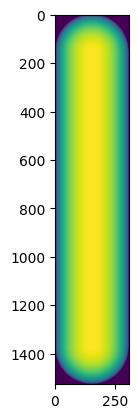

In [46]:
plt.imshow(OPL_cell)

In [17]:
sim_params_unID = [
    (x, y, z, w, v) 
    for x in N_molecules 
    for y in lengths 
    for z in widths if z<=y 
    for w in diffraction_limits 
    for v in wavelengths]#*10

In [18]:
sim_params = []
for i, sim_param in enumerate(sim_params_unID):
    sim_params.append(sim_param + (i,))
    
sim_params = sim_params*500
len(sim_params)

9570000

In [19]:
9570000/275000

34.8

In [20]:
true, obs, volume, ID = zip(*Parallel(n_jobs=6)(delayed(simulate_molecule_counting)(*x) for x in tqdm(sim_params)))
sim_output = pd.DataFrame(sim_params)
sim_output.drop(columns=0, inplace=True)
sim_output.columns = ["Length (micron)", "Width (micron)", "Diffraction Criterion" ,"Wavelength (um)", "ID"]
sim_output["N molecules"] = true
sim_output["Observed molecules"] = obs
sim_output["% error"] = sim_output.apply(lambda x: abs(perc_diff(x["Observed molecules"], x["N molecules"])), axis=1)
sim_output["Aspect ratio"] = sim_output["Length (micron)"]/sim_output["Width (micron)"]
sim_output["Cell volume (micron^3)"] = volume
sim_output.to_pickle(f"sim_output_NEW.pickle")

  0%|          | 0/9570000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Restricted subset for higher sampling for figure

In [65]:
N_molecules = np.arange(1, 21)+0.1
diffraction_limits = ["Rayleigh"]
lengths = np.arange(1,11,1)
widths = np.arange(1,11,1)
imaging_properties = ((0.0655, 1.45))
wavelengths = (0.4, ) 
sim_params_unID = [
    (x, y, z, w, v) 
    for x in N_molecules 
    for y in lengths 
    for z in widths if z<=y 
    for w in diffraction_limits 
    for v in wavelengths]#*10
sim_params = []
for i, sim_param in enumerate(sim_params_unID):
    sim_params.append(sim_param + (i,))
    
sim_params = sim_params*5000
len(sim_params)

5500000

In [40]:
true, obs, volume, ID = zip(*Parallel(n_jobs=12)(delayed(simulate_molecule_counting)(*x) for x in tqdm(sim_params)))
sim_output = pd.DataFrame(sim_params)
sim_output.drop(columns=0, inplace=True)
sim_output.columns = ["Length (micron)", "Width (micron)", "Diffraction Criterion" ,"Wavelength (um)", "ID"]
sim_output["N molecules"] = true
sim_output["Observed molecules"] = obs
sim_output["% error"] = sim_output.apply(lambda x: abs(perc_diff(x["Observed molecules"], x["N molecules"])), axis=1)
sim_output["Aspect ratio"] = sim_output["Length (micron)"]/sim_output["Width (micron)"]
sim_output["Cell volume (micron^3)"] = volume
sim_output.to_pickle(f"sim_output_for_figure.pickle")

  0%|          | 0/5500000 [00:00<?, ?it/s]

In [15]:
FL_PSF = PSF_generator(
    radius = 150,
    wavelength = 0.5,
    NA = 1.49,
    n = 1.518,
    resize_amount = 1,
    pix_mic_conv = pixel_size,
    apo_sigma = 2,
    mode="3d fluo",
    condenser = "Ph3",
    z_height = 100
)
FL_PSF.calculate_PSF()
FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)

For figure

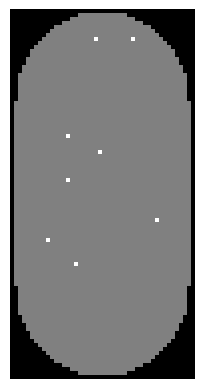

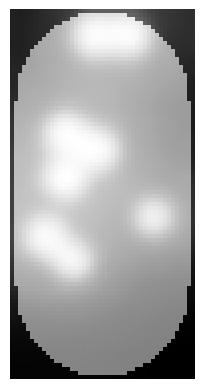

In [57]:
length = 2
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
volume = np.sum(OPL_cell)
density = 8/volume
FL_cell = OPL_to_FL(OPL_cell, density = density)
plt.imshow(OPL_cell > 0, cmap="Greys_r")
plt.imshow(FL_cell, alpha = 0.5, cmap="Greys_r")
plt.axis("off")
plt.show()

FL_cell_conv = convolve_rescale(FL_cell, FL_PSF.kernel, 1, rescale_int = True)
plt.imshow(OPL_cell > 0, cmap="Greys_r")
plt.imshow(FL_cell_conv,alpha=0.5, cmap="Greys_r")
plt.axis("off")
plt.show()

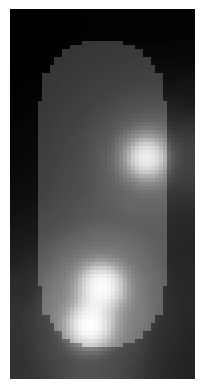

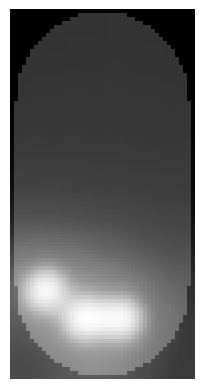

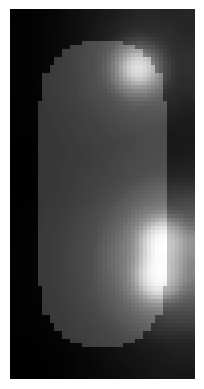

In [53]:
length = 2
width = 1
FL_cells = []
FL_cell_convs = []
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cells = [OPL_cell * (OPL_cell>15), OPL_cell, OPL_cell * (OPL_cell>15)]
for OPL_cell in OPL_cells:
    
    volume = np.sum(OPL_cell)
    density = 3/volume

    FL_cell = OPL_to_FL(OPL_cell, density = density)
    FL_cells.append(FL_cell)
    
    FL_cell_conv = convolve_rescale(FL_cell, FL_PSF.kernel, 1, rescale_int = True)
    FL_cell_convs.append(FL_cell_conv)
    
for FL_cell_conv, OPL_cell in zip(FL_cell_convs, OPL_cells):
    plt.imshow(OPL_cell > 0, cmap="Greys_r")
    plt.imshow(FL_cell_conv, alpha = 0.8, cmap="Greys_r")
    plt.axis("off")
    plt.show()



In [54]:
FL_cell = np.sum(FL_cell_convs, axis=0)

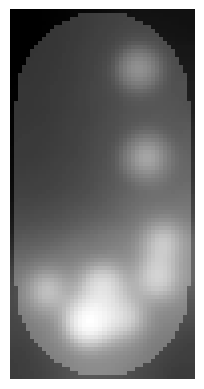

In [55]:
FL_cell = np.sum(FL_cell_convs, axis=0)
plt.imshow(OPL_cells[1] > 0, cmap="Greys_r")
plt.imshow(FL_cell, alpha = 0.8, cmap="Greys_r")
plt.axis("off")
plt.show()